# NN with only Convolution Layers for 1 Track Events (find hit location)

In [1]:

# System imports
import math
from __future__ import print_function

# Standard imports
import sys
import numpy as np
from tempfile import TemporaryFile

# Python Externa Imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Keras Imports
from keras import models
from keras import layers
import keras.backend as K
from keras.regularizers import l2


# Local imports
from local_modules import generate_data, track_hit_coords, drawMulti_from_params_pix, draw_from_params, get_Alist_pulls

# Magic
%matplotlib inline

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:04:00.0)


In [2]:
#data = np.load('/bigdata/atsaris/train_data.npz')
data = np.load('/bigdata/atsaris/new/data1trk.npz')
#data = np.load('/home/atsaris/hepTrack_newY_test/23_04_2017/train_data_test.npz') # use it for test

In [3]:
# Model
def build_model_2():
    """Test model.  Consists of several convolutional layers followed by dense layers and an output layer"""
    input_layer = layers.Input(shape=(1, num_det_layers, det_layer_size, det_layer_size))
    layer = layers.Convolution3D(8, 3, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution3D(8, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling3D(pool_size=(2,2,2))(layer)
    layer = layers.Convolution3D(16, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution3D(16, 3, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(40)(layer)
    layer = layers.Dense((2*num_det_layers)*max_tracks)(layer)
    output_layer = layers.Reshape((max_tracks,(2*num_det_layers)))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam', sample_weight_mode="temporal", metrics=['accuracy'])
    return model

Max_tracks:  1
Num_tracks:  1
epoch_size:  64000
num_epochs:  10

[[  6.86333601  27.38276798   6.1534043   25.59764877   5.44347259
   23.81252955   4.73354088  22.02741034   4.02360917  20.24229112
    3.31367745  18.45717191   2.60374574  16.67205269   1.89381403
   14.88693348   1.18388232  13.10181426   0.47395061  11.31669505]] 

[[ -0.70993171  -1.78511922   6.86333601  27.38276798]]


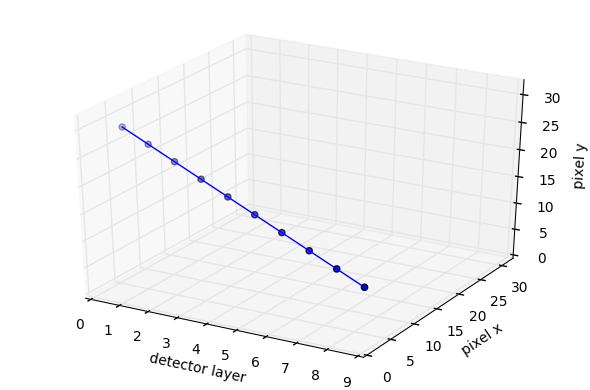

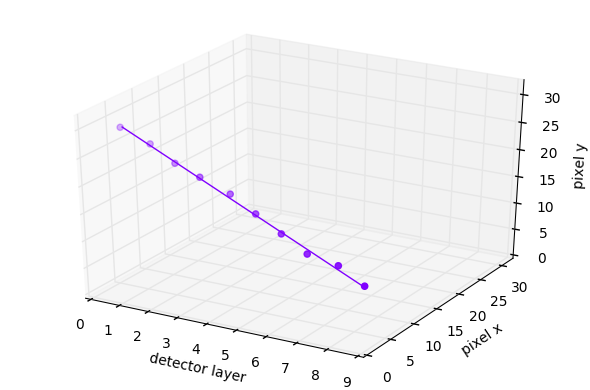

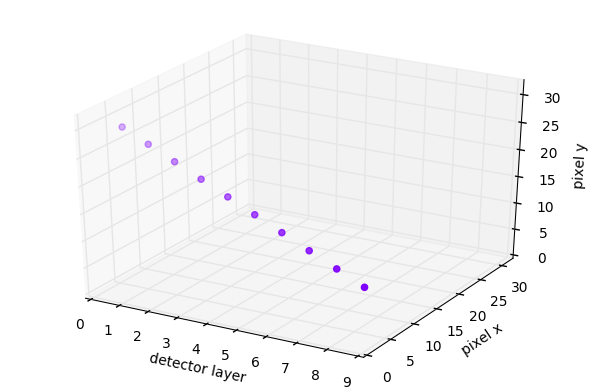

In [4]:
# Configuration
num_det_layers = data['num_det_layers']
det_layer_size = data['det_layer_size']
num_seed_layers = 0
avg_bkg_tracks = 0
noise_prob = 0.0
det_shape = (num_det_layers, det_layer_size, det_layer_size)

max_tracks = data['max_tracks']
num_tracks = data['num_tracks']

# Training parameters
batch_size = data['batch_size']
epoch_size = data['epoch_size']
num_epochs = data['num_epochs']

print("Max_tracks: ", max_tracks)
print("Num_tracks: ", num_tracks)
print("epoch_size: ", epoch_size)
print("num_epochs: ", num_epochs)

events = data['events']
targets_par = data['target_slope']
targets_pix = data['target_slope_pix']
weights = data['weights']

# Make sure input to NN is OK
test_index = np.random.randint(epoch_size)
test_event = events[test_index]
test_target_par = targets_par[test_index]
test_target_pix = targets_pix[test_index]
print("")
#print(test_event, "\n")
print(test_target_pix, "\n")
print(test_target_par)
draw_from_params(test_target_par, num_det_layers, det_layer_size)
drawMulti_from_params_pix(num_tracks, test_target_par, num_det_layers, det_layer_size, True)
drawMulti_from_params_pix(num_tracks, test_target_pix, num_det_layers, det_layer_size)

In [5]:
# Train the model
model_2 = build_model_2()
history = model_2.fit(events, targets_pix, batch_size=batch_size, nb_epoch=num_epochs, 
           validation_split=0.1, sample_weight=weights)

Train on 57600 samples, validate on 6400 samples
Epoch 1/10
57600/57600 [==============================] - 79s - loss: 6.9934 - acc: 0.7875 - val_loss: 0.1737 - val_acc: 0.9206
Epoch 2/10
57600/57600 [==============================] - 96s - loss: 0.1160 - acc: 0.9373 - val_loss: 0.0822 - val_acc: 0.9383
Epoch 3/10
57600/57600 [==============================] - 96s - loss: 0.0938 - acc: 0.9473 - val_loss: 0.0679 - val_acc: 0.9586
Epoch 4/10
57600/57600 [==============================] - 96s - loss: 0.0801 - acc: 0.9494 - val_loss: 0.2395 - val_acc: 0.9563
Epoch 5/10
57600/57600 [==============================] - 96s - loss: 0.0730 - acc: 0.9530 - val_loss: 0.0904 - val_acc: 0.9552
Epoch 6/10
57600/57600 [==============================] - 96s - loss: 0.0768 - acc: 0.9547 - val_loss: 0.0668 - val_acc: 0.9613
Epoch 7/10
57600/57600 [==============================] - 96s - loss: 0.0659 - acc: 0.9563 - val_loss: 0.0478 - val_acc: 0.9663
Epoch 8/10
57600/57600 [==============================]

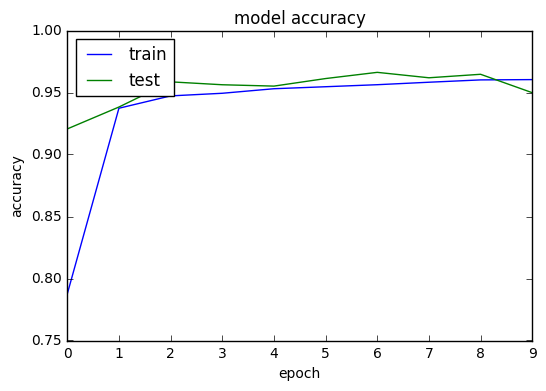

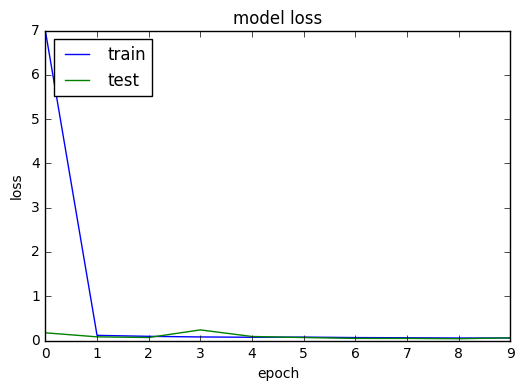

In [6]:
# Plot the accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
test_data = np.load('/bigdata/atsaris/new/test1trk.npz')
train_events = test_data['events']
train_targets_slope = test_data['target_slope']
train_targets_slope_pix = test_data['target_slope_pix']
train_weights = test_data['weights']

In [10]:
for i in range(0, 2*num_det_layers):
    mu, sigma = get_Alist_pulls(model_2, 1000, train_events, train_weights, train_targets_slope_pix, i, False)
    print("pixel (μ, σ): ", mu, sigma)

pixel (μ, σ):  -0.127493809279 0.235596097385
pixel (μ, σ):  -0.0509723297768 0.258866728046
pixel (μ, σ):  -0.294310283939 0.208255917695
pixel (μ, σ):  -0.182585664835 0.21607933345
pixel (μ, σ):  -0.27033989005 0.174801079071
pixel (μ, σ):  -0.0778657686897 0.177354529657
pixel (μ, σ):  -0.038900114888 0.139075331183
pixel (μ, σ):  0.0237599358447 0.157833841902
pixel (μ, σ):  -0.217880282284 0.128467556343
pixel (μ, σ):  -0.21239626408 0.13539459677
pixel (μ, σ):  -0.0685109914618 0.126865333556
pixel (μ, σ):  -0.0694257552586 0.147135438981
pixel (μ, σ):  -0.141100740507 0.148639958598
pixel (μ, σ):  0.00536703987053 0.150108359997
pixel (μ, σ):  -0.176854458651 0.167681610885
pixel (μ, σ):  -0.0702151942066 0.176923850741
pixel (μ, σ):  -0.0341595826428 0.200609782849
pixel (μ, σ):  -0.0999938967562 0.206706822694
pixel (μ, σ):  -0.122617929337 0.239455389112
pixel (μ, σ):  -0.178516341757 0.245678196566


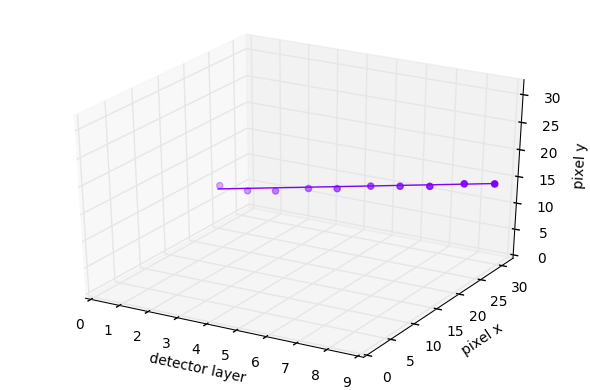

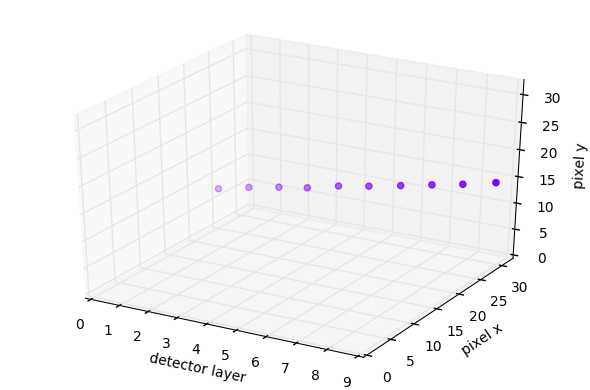

In [9]:
test_index = np.random.randint(0,test_data['epoch_size'])
# Draw Truth
test_weights = train_weights[test_index].astype(np.bool_)
test_a_tmp = train_targets_slope_pix[test_index][test_weights]
test_a = train_targets_slope[test_index][test_weights]
drawMulti_from_params_pix(num_tracks, test_a, num_det_layers, det_layer_size, True)
#drawMulti_from_params_pix(num_tracks, test_a_tmp, num_det_layers, det_layer_size)

# Draw Prediction
test_event = train_events[test_index]
test_pred = model_2.predict(np.asarray([test_event]))[0][test_weights]
drawMulti_from_params_pix(num_tracks, test_pred, num_det_layers, det_layer_size)